# Music Popularity Analysis

<hr style="border:2px solid black"> </hr>

## Notebook 05 - API Join

---

### Import libraries

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [59]:
def num_uniques(ser):
    try:
        return len(ser.unique())
    except:
        return "Not unique check-able"

In [60]:
def summarize_df(df):
    print("======DATA SUMMARY======")
    print("{} rows by {} columns".format(df.shape[0], df.shape[1]))
    print("\n======COLUMNS======")
    print(df.dtypes)
    print("\n======PREVIEW======")
    display(df.head())
    print("\n======NUMERICAL COL SUMMARY======")
    print(df.describe())
    print("\n")
    for col in df.columns:
        print("{}: {} unique values".format(col, num_uniques(df[col])))

In [61]:
def quicksum(df):
    print("======DATA SUMMARY======")
    print("{} rows by {} columns".format(df.shape[0], df.shape[1]))
    print("\n======PREVIEW======")
    display(df.head())
    for col in df.columns:
        print("{}: {} unique values".format(col, num_uniques(df[col])))

---
### Import data

In [62]:
# Read in last.fm release + track + play count
lfm_count = pd.read_csv('gid_name_art_count.csv', usecols=[1, 2, 3, 4], skiprows=1,
                        names=['mb_release_gid', 'lfm_track_name', 'lfm_artist_name', 'lfm_play_count'])
quicksum(lfm_count)

======DATA SUMMARY======
237916 rows by 4 columns

======PREVIEW======


,mb_release_gid,lfm_track_name,lfm_artist_name,lfm_play_count
0,5c8fd7dd-e054-44b3-b7d4-1b422b8c344a,爽やかなる決意,伊賀拓郎,137
1,5c8fd7dd-e054-44b3-b7d4-1b422b8c344a,私に天使が舞い降りた！ I,伊賀拓郎,4
2,5c8fd7dd-e054-44b3-b7d4-1b422b8c344a,私に天使が舞い降りた！ II,伊賀拓郎,79
3,5c8fd7dd-e054-44b3-b7d4-1b422b8c344a,みやこエキサイト,伊賀拓郎,104
4,5c8fd7dd-e054-44b3-b7d4-1b422b8c344a,幸せな一日,伊賀拓郎,116


mb_release_gid: 17794 unique values
lfm_track_name: 135098 unique values
lfm_artist_name: 9505 unique values
lfm_play_count: 60441 unique values


In [63]:
# Aggregate last.fm release + track + play count
lfm_rel_name = lfm_count[['mb_release_gid', 'lfm_track_name', 'lfm_artist_name', 'lfm_play_count']].groupby(['mb_release_gid', 'lfm_track_name' , 'lfm_artist_name', 'lfm_play_count'], as_index=False).size()
quicksum(lfm_rel_name)
lfm_rel_name = lfm_rel_name.drop('size', axis=1)

======DATA SUMMARY======
233372 rows by 5 columns

======PREVIEW======


,mb_release_gid,lfm_track_name,lfm_artist_name,lfm_play_count,size
0,0000729a-8ad0-4e0f-8dfe-13c1e0b73274,まほう,花譜,3200,1
1,0000729a-8ad0-4e0f-8dfe-13c1e0b73274,アンサー,花譜,40778,1
2,0000729a-8ad0-4e0f-8dfe-13c1e0b73274,メルの黄昏,花譜,3875,1
3,0000729a-8ad0-4e0f-8dfe-13c1e0b73274,モンタージュ,花譜,5875,1
4,0000729a-8ad0-4e0f-8dfe-13c1e0b73274,世界線は分岐する -Instrumental-,花譜,19,1


mb_release_gid: 17794 unique values
lfm_track_name: 135098 unique values
lfm_artist_name: 9505 unique values
lfm_play_count: 60441 unique values
size: 15 unique values


In [64]:
# Cleansing to prep for fuzzy matching (lowercase, alphanumeric)
# lfm_rel_name['lfm_rel_name_prcs'] = lfm_rel_name['lfm_track_name'].apply(lambda x: ''.join([s.lower() for s in x if s.isalnum()]))

In [65]:
# Custom function to generate a list of track names and dictionary of track names to play counts
def groupfunc(df):
    d = {}
    d['mb_release_gid'] = df['mb_release_gid']
    d['lfm_track_names'] = df['lfm_track_name'].values.tolist()
    d['lfm_play_counts'] = dict([(k, df['lfm_play_count'].values.tolist()[i]) for i, k in enumerate(df['lfm_track_name'].values.tolist())])
    return pd.Series(d)

In [66]:
lfm_rel_ids = lfm_rel_name.groupby('mb_release_gid', as_index=False).apply(groupfunc)
lfm_rel_ids['mb_release_gid'] = lfm_rel_ids['mb_release_gid'].apply(lambda x: x.iloc[0])
quicksum(lfm_rel_ids)

======DATA SUMMARY======
17794 rows by 3 columns

======PREVIEW======


,mb_release_gid,lfm_track_names,lfm_play_counts
0,0000729a-8ad0-4e0f-8dfe-13c1e0b73274,"[まほう, アンサー, メルの黄昏, モンタージュ, 世界線は分岐する -Instrumen...","{'まほう': 3200, 'アンサー': 40778, 'メルの黄昏': 3875, 'モ..."
1,00049aaf-1266-482b-9f6b-2672092c68f4,"[Breathe (Taylor's version), Bye Bye Baby (Fro...","{'Breathe (Taylor's version)': 6133, 'Bye Bye ..."
2,00134ced-5671-494b-944d-6d4d2645af2f,"[Doors Of The City, Frozen Place, No Paradise,...","{'Doors Of The City': 39, 'Frozen Place': 33, ..."
3,001c5d95-7da9-4a09-b940-095491765fc2,"[4ÆM, Before the fever, Darkseid, Delete Forev...","{'4ÆM': 1979923, 'Before the fever': 595943, '..."
4,001c68d5-22f3-4ea1-8bac-02521e62c7d9,"[As Many Candles As Possible, Bell Swamp Conne...","{'As Many Candles As Possible': 54321, 'Bell S..."


mb_release_gid: 17794 unique values
lfm_track_names: Not unique check-able unique values
lfm_play_counts: Not unique check-able unique values


In [67]:
sp_track_artist = pd.read_csv('uri_artist.csv', usecols=[1, 2])
quicksum(sp_track_artist)

======DATA SUMMARY======
50537 rows by 2 columns

======PREVIEW======


,sp_artist_uri,sp_track_uri
0,0xliTEbFfy5HQHvsTknTkX,spotify:track:3BDcuuLSAUCp3V5gtXmU3M
1,5T3loELyNii7mRPeB946WE,spotify:track:3HWIktiW8cv1KcHLc7iYIW
2,1uNFoZAHBGtllmzznpCI3s,spotify:track:75nKBP8jQu681pTNCtrEnn
3,5fmvGUlMVgmnCn45f1he7d,spotify:track:6wGMLoEqD2k3RBXFHD0yUp
4,4ywf1iH1ruKEcfpCgfJvyA,spotify:track:15J6jZN7MM4gG617FyohOQ


sp_artist_uri: 17285 unique values
sp_track_uri: 45991 unique values


In [68]:
sp_track_artist = sp_track_artist.groupby(['sp_artist_uri', 'sp_track_uri'], as_index=False).size()
sp_track_artist['sp_track_uri'] = sp_track_artist['sp_track_uri'].apply(lambda x: x.split(':')[2])
sp_track_artist = sp_track_artist.drop('size', axis=1)
quicksum(sp_track_artist)

======DATA SUMMARY======
45991 rows by 2 columns

======PREVIEW======


,sp_artist_uri,sp_track_uri
0,000w0gZDNX8SiIs05h6Kwe,72qorl4TkbxjPt4GUwfO0u
1,001aJOc7CSQVo3XzoLG4DK,1EvK9FpsE8xQgBdbE0VaUF
2,007MmXwT1HwcXwuyROgNJb,6lbHdRNNrEqh7O7FXxqtlo
3,007nYTXRhZJUZGH7ct5Y3v,6z1LRCM39LEMh5UXvML0VM
4,009hDsrD8KhLjlJGYi7vc4,0efrIBvswXQr9PwaayUGcB


sp_artist_uri: 17285 unique values
sp_track_uri: 45991 unique values


In [70]:
sp_artist_info = sp_artist_info.groupby(list(sp_artist_info.columns), as_index=False).size()
sp_artist_info['sp_artist_uri'] = sp_artist_info['sp_artist_uri'].apply(lambda x: x.split(':')[2])
quicksum(sp_artist_info)
sp_artist_info = sp_artist_info.drop('size', axis=1)

======DATA SUMMARY======
17285 rows by 5 columns

======PREVIEW======


,sp_artist_uri,sp_artist_popularity,sp_genres,sp_artist_followers,size
0,000w0gZDNX8SiIs05h6Kwe,8,[],35,1
1,001aJOc7CSQVo3XzoLG4DK,48,"['classic soul', 'disco', 'electro', 'funk', '...",150108,1
2,007MmXwT1HwcXwuyROgNJb,56,['pinoy singer-songwriter'],5670,1
3,007nYTXRhZJUZGH7ct5Y3v,48,"['future bass', 'indie electropop', 'vapor twi...",17593,1
4,009hDsrD8KhLjlJGYi7vc4,2,[],233,2


sp_artist_uri: 17285 unique values
sp_artist_popularity: 100 unique values
sp_genres: 8826 unique values
sp_artist_followers: 12742 unique values
size: 69 unique values


In [69]:
sp_artist_info = pd.read_csv('artisturi_artistinfo.csv', usecols=[1, 2, 3, 4])
sp_artist_info = sp_artist_info.rename({'sp_popularity': 'sp_artist_popularity'}, axis=1)
quicksum(sp_artist_info)

======DATA SUMMARY======
50537 rows by 4 columns

======PREVIEW======


,sp_artist_uri,sp_artist_popularity,sp_genres,sp_artist_followers
0,spotify:artist:0xliTEbFfy5HQHvsTknTkX,67,"['europop', 'new romantic', 'new wave', 'new w...",617347
1,spotify:artist:5T3loELyNii7mRPeB946WE,4,[],431
2,spotify:artist:1uNFoZAHBGtllmzznpCI3s,96,"['canadian pop', 'pop']",59520636
3,spotify:artist:5fmvGUlMVgmnCn45f1he7d,54,"['soft rock', 'underground power pop']",45127
4,spotify:artist:4ywf1iH1ruKEcfpCgfJvyA,63,"['russian dance', 'russian pop']",1911500


sp_artist_uri: 17285 unique values
sp_artist_popularity: 100 unique values
sp_genres: 8826 unique values
sp_artist_followers: 12742 unique values


In [71]:
sp_track_audiof = pd.read_csv('isrc_uri_audiofeats.csv', usecols = range(1, 15))
quicksum(sp_track_audiof)

======DATA SUMMARY======
50490 rows by 14 columns

======PREVIEW======


,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:3BDcuuLSAUCp3V5gtXmU3M,0.504,0.388,8,-13.254,0,0.0276,0.1330,0.583000,0.1760,0.221,149.504,444760,4
1,spotify:track:3HWIktiW8cv1KcHLc7iYIW,0.244,0.519,0,-8.415,1,0.0400,0.1920,0.001210,0.1640,0.113,72.155,521812,4
2,spotify:track:75nKBP8jQu681pTNCtrEnn,0.774,0.603,11,-7.319,1,0.0591,0.4380,0.000044,0.0869,0.977,149.982,179627,4
3,spotify:track:6wGMLoEqD2k3RBXFHD0yUp,0.588,0.598,9,-13.288,1,0.0296,0.0386,0.000058,0.1070,0.866,123.724,264893,4
4,spotify:track:15J6jZN7MM4gG617FyohOQ,0.653,0.862,7,-4.900,1,0.0749,0.1650,0.000002,0.7460,0.486,130.005,197933,4


uri: 45948 unique values
danceability: 1115 unique values
energy: 2002 unique values
key: 12 unique values
loudness: 17475 unique values
mode: 2 unique values
speechiness: 1442 unique values
acousticness: 4658 unique values
instrumentalness: 5123 unique values
liveness: 1672 unique values
valence: 1648 unique values
tempo: 30060 unique values
duration_ms: 33849 unique values
time_signature: 5 unique values


In [72]:
sp_track_audiof = sp_track_audiof.groupby(list(sp_track_audiof.columns), as_index=False).size()
sp_track_audiof = sp_track_audiof.drop('size', axis=1)
sp_track_audiof.columns = ['sp_'+x for x in sp_track_audiof.columns]
sp_track_audiof['sp_track_uri'] = sp_track_audiof['sp_uri'].apply(lambda x: x.split(':')[2])
sp_track_audiof = sp_track_audiof.drop('sp_uri', axis=1)
quicksum(sp_track_audiof)

======DATA SUMMARY======
45948 rows by 14 columns

======PREVIEW======


,sp_danceability,sp_energy,sp_key,sp_loudness,sp_mode,sp_speechiness,sp_acousticness,sp_instrumentalness,sp_liveness,sp_valence,sp_tempo,sp_duration_ms,sp_time_signature,sp_track_uri
0,0.600,0.714,9,-9.184,1,0.0426,0.050200,0.000016,0.180,0.5650,119.838,246267,4,002R5aYQAMYD0jEZf2mAbz
1,0.537,0.527,2,-8.060,1,0.0318,0.007100,0.002840,0.368,0.4220,75.907,333010,4,002yzPc8YY5JfHhcYDfkTZ
2,0.842,0.578,6,-6.050,0,0.1380,0.004190,0.000000,0.228,0.1900,74.496,236779,4,003VDDA7J3Xb2ZFlNx7nIZ
3,0.631,0.704,0,-7.322,1,0.0316,0.000025,0.137000,0.127,0.9430,133.972,440601,4,003ryCWydz9DQsjBFXD8L1
4,0.350,0.587,4,-5.603,1,0.0344,0.141000,0.000273,0.283,0.0918,173.709,170653,3,003xNaWRMtF3NKEj32kycd


sp_danceability: 1115 unique values
sp_energy: 2002 unique values
sp_key: 12 unique values
sp_loudness: 17475 unique values
sp_mode: 2 unique values
sp_speechiness: 1442 unique values
sp_acousticness: 4658 unique values
sp_instrumentalness: 5123 unique values
sp_liveness: 1672 unique values
sp_valence: 1648 unique values
sp_tempo: 30060 unique values
sp_duration_ms: 33849 unique values
sp_time_signature: 5 unique values
sp_track_uri: 45948 unique values


In [73]:
sp_uri_isrc = pd.read_csv('isrc_uri.csv', usecols=[1, 2])
quicksum(sp_uri_isrc)

======DATA SUMMARY======
50537 rows by 2 columns

======PREVIEW======


,isrc,sp_uri
0,DEA622100038,3BDcuuLSAUCp3V5gtXmU3M
1,QZES92183707,3HWIktiW8cv1KcHLc7iYIW
2,USUM72001306,75nKBP8jQu681pTNCtrEnn
3,USEE10183941,6wGMLoEqD2k3RBXFHD0yUp
4,RUA582002334,15J6jZN7MM4gG617FyohOQ


isrc: 45937 unique values
sp_uri: 45991 unique values


In [74]:
sp_uri_isrc_c = sp_uri_isrc.groupby(['isrc', 'sp_uri'], as_index=False).size().drop('size', axis=1)
sp_uri_isrc = sp_uri_isrc_c.groupby('isrc', as_index=False).agg({'sp_uri': ['first', 'count']})
sp_uri_isrc.columns = ['isrc','sp_track_uri', 'sp_uri_count']
sp_uri_isrc = sp_uri_isrc[sp_uri_isrc['sp_uri_count'] == 1].drop('sp_uri_count', axis=1)
quicksum(sp_uri_isrc)

======DATA SUMMARY======
45883 rows by 2 columns

======PREVIEW======


,isrc,sp_track_uri
0,AEA0D1937329,19JIYDxouJVup6Vju4XbHl
1,AEA0D2023070,3eogtRRuMwtTuf1QBphQlo
2,AEA0D2072523,6E0mQk3LKvJ0xBvDA7ujxH
3,AEA0D2084900,6DQKbMorKoc8I5dm72bZJi
4,AEA0Q1843819,0fopKx0lC8B036jTNysxyv


isrc: 45883 unique values
sp_track_uri: 45883 unique values


In [75]:
mb_db_songs = pd.read_parquet('mb_db_songs_2019.parquet')[['release_gid', 'isrc', 'track_name']] \
                .rename({'release_gid': 'mb_release_gid', 'track_name':'mb_track_name'}, axis=1)
quicksum(mb_db_songs)

======DATA SUMMARY======
901913 rows by 3 columns

======PREVIEW======


,mb_release_gid,isrc,mb_track_name
168,3c501e34-f3fa-4860-8115-25b587ac2bef,USSK41300025,Wonder Girl
202,3c501e34-f3fa-4860-8115-25b587ac2bef,USSK41300028,Girl From Germany
336,3c501e34-f3fa-4860-8115-25b587ac2bef,GBAAN7400025,This Town Ain't Big Enough for Both of Us
455,3c501e34-f3fa-4860-8115-25b587ac2bef,GBAAN7400026,Amateur Hour
730,29b77556-8bfb-42e0-b8ea-2e3b45300f69,GBAAA9100034,Unfinished Sympathy (2006 Digital Remaster)


mb_release_gid: 109387 unique values
isrc: 504586 unique values
mb_track_name: 402402 unique values


In [76]:
working_df = mb_db_songs.copy()
working_df['mb_track_name'] = working_df['mb_track_name'].fillna('')
working_df = working_df.merge(sp_uri_isrc, on='isrc')
quicksum(working_df)

======DATA SUMMARY======
146162 rows by 4 columns

======PREVIEW======


,mb_release_gid,isrc,mb_track_name,sp_track_uri
0,3c501e34-f3fa-4860-8115-25b587ac2bef,GBAAN7400026,Amateur Hour,1C5Pxs8JpgQ2sWin9h1d7i
1,b6118ea8-ea87-4d97-a3fc-951c1b792c81,GBAAN7400026,Amateur Hour,1C5Pxs8JpgQ2sWin9h1d7i
2,29b77556-8bfb-42e0-b8ea-2e3b45300f69,GBAAA9100034,Unfinished Sympathy (2006 Digital Remaster),28jaG0nLqlijtHGQzZqGWK
3,260e8789-d30e-436c-8232-a34adfdf9681,GBAAA9100034,Unfinished Sympathy,28jaG0nLqlijtHGQzZqGWK
4,3c501e34-f3fa-4860-8115-25b587ac2bef,GBAAN7400031,Never Turn Your Back on Mother Earth,3Wp1bQyFq7nRUhG2EzVqZE


mb_release_gid: 47472 unique values
isrc: 45883 unique values
mb_track_name: 48180 unique values
sp_track_uri: 45883 unique values


In [77]:
working_df = working_df.merge(lfm_rel_ids, on='mb_release_gid')
quicksum(working_df)

======DATA SUMMARY======
61907 rows by 6 columns

======PREVIEW======


,mb_release_gid,isrc,mb_track_name,sp_track_uri,lfm_track_names,lfm_play_counts
0,40da1824-821b-42dc-a29a-ac12e34cde2f,USUM71918740,Alanis’ Interlude,6ZmwwHYtun94UOdFWWgdif,"[3am, 929, Alanis' Interlude, Ashley, Dominic'...","{'3am': 1243869, '929': 662955, 'Alanis' Inter..."
1,40da1824-821b-42dc-a29a-ac12e34cde2f,USUM71918762,SUGA’s Interlude,1ZoQVu9XBssJBdeKMgF2eV,"[3am, 929, Alanis' Interlude, Ashley, Dominic'...","{'3am': 1243869, '929': 662955, 'Alanis' Inter..."
2,40da1824-821b-42dc-a29a-ac12e34cde2f,USUM71918756,More,3jgHKbpswygyOMipFz06RQ,"[3am, 929, Alanis' Interlude, Ashley, Dominic'...","{'3am': 1243869, '929': 662955, 'Alanis' Inter..."
3,40da1824-821b-42dc-a29a-ac12e34cde2f,USUM71923948,I’m Not Mad,6SL8U8TtdwOtGhbmGzsMfX,"[3am, 929, Alanis' Interlude, Ashley, Dominic'...","{'3am': 1243869, '929': 662955, 'Alanis' Inter..."
4,40da1824-821b-42dc-a29a-ac12e34cde2f,USUM71918342,clementine,7ozvM98YyrdyOBh1lItVHc,"[3am, 929, Alanis' Interlude, Ashley, Dominic'...","{'3am': 1243869, '929': 662955, 'Alanis' Inter..."


mb_release_gid: 17784 unique values
isrc: 29786 unique values
mb_track_name: 29642 unique values
sp_track_uri: 29786 unique values
lfm_track_names: Not unique check-able unique values
lfm_play_counts: Not unique check-able unique values


In [78]:
working_df = working_df.groupby(['isrc', 'sp_track_uri'], as_index=False).first()
working_df.columns = [''.join(x) for x in working_df.columns]
quicksum(working_df)

======DATA SUMMARY======
29786 rows by 6 columns

======PREVIEW======


,isrc,sp_track_uri,mb_release_gid,mb_track_name,lfm_track_names,lfm_play_counts
0,AEA0D1937329,19JIYDxouJVup6Vju4XbHl,10fd2bac-ab04-4eb8-8428-f2068923bdf7,My Wasteland,"[Echoes in Me, Hate, In Your Nightmares, Linda...","{'Echoes in Me': 12, 'Hate': 25, 'In Your Nigh..."
1,AEA0D2084900,6DQKbMorKoc8I5dm72bZJi,4ac930af-fd16-4397-ba4c-f3727331d2c4,Hakuna Matata,"[A Spoonful of Sugar, Hakuna Matata, Kisse the...","{'A Spoonful of Sugar': 26, 'Hakuna Matata': 4..."
2,AEA0Q1967586,6k2GJRe3u6wHqaXL9XCt74,0df23deb-d8b5-4ef8-ae16-6865f6facc22,Farcry,"[Farcry, Impossible]","{'Farcry': 2, 'Impossible': 3}"
3,AEA0Q2041540,6xCie6yrUQh0McImPanmGq,88532401-a81e-4af7-bcfa-397ce6c4f6cc,Self Isolation,"[After Work, Covid, Memory, Runaway, Self Isol...","{'After Work': 1524, 'Covid': 1154, 'Memory': ..."
4,AEA268600007,1xoQ7aj6Ms73PCJ3Q5UPTe,0c8b2548-0d6f-47e9-bf0a-60e32f14690a,A Hundred Words,"[A Hundred Words, Forever Dancing, If Only '87...","{'A Hundred Words': 7022, 'Forever Dancing': 3..."


isrc: 29786 unique values
sp_track_uri: 29786 unique values
mb_release_gid: 12723 unique values
mb_track_name: 27371 unique values
lfm_track_names: Not unique check-able unique values
lfm_play_counts: Not unique check-able unique values


In [79]:
working_df['match'] = working_df.apply(lambda x: process.extractOne(x['mb_track_name'], x['lfm_track_names']), axis=1)

In [80]:
working_df['matched'] = working_df['match'].apply(lambda x: x[0])
working_df['score'] = working_df['match'].apply(lambda x: x[1])
working_df['play_count'] = working_df.apply(lambda x: x['lfm_play_counts'][x['matched']], axis=1)

In [81]:
working_df['play_count'] = working_df.apply(lambda x: x['lfm_play_counts'][x['matched']], axis=1)

In [82]:
summarize_df(working_df)

======DATA SUMMARY======
29786 rows by 10 columns

======COLUMNS======
isrc               object
sp_track_uri       object
mb_release_gid     object
mb_track_name      object
lfm_track_names    object
lfm_play_counts    object
match              object
matched            object
score               int64
play_count          int64
dtype: object

======PREVIEW======


,isrc,sp_track_uri,mb_release_gid,mb_track_name,lfm_track_names,lfm_play_counts,match,matched,score,play_count
0,AEA0D1937329,19JIYDxouJVup6Vju4XbHl,10fd2bac-ab04-4eb8-8428-f2068923bdf7,My Wasteland,"[Echoes in Me, Hate, In Your Nightmares, Linda...","{'Echoes in Me': 12, 'Hate': 25, 'In Your Nigh...","(My Wasteland, 100)",My Wasteland,100,5
1,AEA0D2084900,6DQKbMorKoc8I5dm72bZJi,4ac930af-fd16-4397-ba4c-f3727331d2c4,Hakuna Matata,"[A Spoonful of Sugar, Hakuna Matata, Kisse the...","{'A Spoonful of Sugar': 26, 'Hakuna Matata': 4...","(Hakuna Matata, 100)",Hakuna Matata,100,45
2,AEA0Q1967586,6k2GJRe3u6wHqaXL9XCt74,0df23deb-d8b5-4ef8-ae16-6865f6facc22,Farcry,"[Farcry, Impossible]","{'Farcry': 2, 'Impossible': 3}","(Farcry, 100)",Farcry,100,2
3,AEA0Q2041540,6xCie6yrUQh0McImPanmGq,88532401-a81e-4af7-bcfa-397ce6c4f6cc,Self Isolation,"[After Work, Covid, Memory, Runaway, Self Isol...","{'After Work': 1524, 'Covid': 1154, 'Memory': ...","(Self Isolation, 100)",Self Isolation,100,1631
4,AEA268600007,1xoQ7aj6Ms73PCJ3Q5UPTe,0c8b2548-0d6f-47e9-bf0a-60e32f14690a,A Hundred Words,"[A Hundred Words, Forever Dancing, If Only '87...","{'A Hundred Words': 7022, 'Forever Dancing': 3...","(A Hundred Words, 100)",A Hundred Words,100,7022



======NUMERICAL COL SUMMARY======
             score    play_count
count  29786.00000  2.978600e+04
mean      93.13503  1.937029e+05
std       18.05461  9.130322e+05
min        0.00000  0.000000e+00
25%      100.00000  1.342500e+02
50%      100.00000  2.390000e+03
75%      100.00000  3.376075e+04
max      100.00000  2.399470e+07


isrc: 29786 unique values
sp_track_uri: 29786 unique values
mb_release_gid: 12723 unique values
mb_track_name: 27371 unique values
lfm_track_names: Not unique check-able unique values
lfm_play_counts: Not unique check-able unique values
match: 27315 unique values
matched: 25767 unique values
score: 95 unique values
play_count: 14912 unique values


In [83]:
working_df = working_df.merge(sp_track_audiof, on='sp_track_uri') \
                        .merge(sp_track_artist, on='sp_track_uri') \
                        .merge(sp_artist_info, on='sp_artist_uri') \
                        .drop(['lfm_track_names', 'lfm_play_counts', 'match'], axis=1)

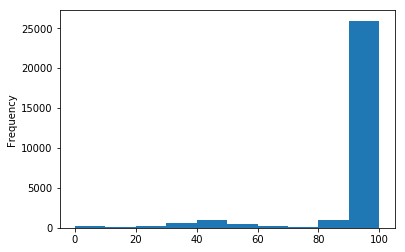

In [84]:
working_df['score'].plot.hist()

In [85]:
working_df[working_df['score'] >= 80].to_parquet('song_data.parquet')